In [2]:
! pip install segmentation_models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 12.7 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D
from keras.models import Model
from keras.utils import normalize
import segmentation_models as sm
from sklearn.model_selection import train_test_split


#path sorting
import glob
import cv2
from pathlib import Path
import re

#math
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd

Segmentation Models: using `keras` framework.


In [6]:
training_path = "../datasets/"

X = []
Y = []



#regex pattern I copied to sort filepaths in ascending order
file_pattern = re.compile(r'.*?(\d+).*?')
def get_order(file):
    match = file_pattern.match(Path(file).name)
    if not match:
        return math.inf
    return int(match.groups()[0])

In [157]:

for img_path in sorted(glob.glob(training_path+"light_spokes_training_images/*.png"), key=get_order):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    X.append(img)

    
    
for mask_path in sorted(glob.glob(training_path+"light_spokes_training_masks/*.png"), key=get_order):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask[mask != 0] = 255
    Y.append(mask)

X = normalize(np.array(X), axis=1)
Y = (np.array(Y))/255.

In [158]:
# train/test split
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)

In [159]:
SIZE_Y, SIZE_X = X.shape[1], X.shape[2]
# 160, 736

In [160]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(119, 160, 736)
(21, 160, 736)
(119, 160, 736)
(21, 160, 736)


In [161]:
model = sm.Unet(backbone_name="resnet34", encoder_weights = None, input_shape=(SIZE_Y,SIZE_X, 1))
model.compile(optimizer = "Adam" , loss = "binary_crossentropy", metrics = [sm.metrics.IOUScore()], )
print(model.summary())

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 160, 736, 1  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 160, 736, 1)  3           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_68 (ZeroPadding  (None, 166, 742, 1)  0          ['bn_data[0][0]']                
 2D)                                                                                              
                                                                                            

In [162]:
history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=10,
   epochs=300,
   verbose=1,
   validation_split=.16
)

Epoch 1/300
10/10 [==============================] - 6s 216ms/step - loss: 0.5603 - iou_score: 0.0143 - val_loss: 5.5118 - val_iou_score: 2.3514e-11
Epoch 2/300
10/10 [==============================] - 1s 136ms/step - loss: 0.2693 - iou_score: 0.0150 - val_loss: 11.0553 - val_iou_score: 0.0150
Epoch 3/300
10/10 [==============================] - 1s 136ms/step - loss: 0.1734 - iou_score: 0.0163 - val_loss: 7.1748 - val_iou_score: 0.0110
Epoch 4/300
10/10 [==============================] - 1s 136ms/step - loss: 0.1331 - iou_score: 0.0172 - val_loss: 0.1704 - val_iou_score: 1.5148e-09
Epoch 5/300
10/10 [==============================] - 1s 136ms/step - loss: 0.1084 - iou_score: 0.0252 - val_loss: 3.3016 - val_iou_score: 9.0971e-04
Epoch 6/300
10/10 [==============================] - 1s 135ms/step - loss: 0.0927 - iou_score: 0.0285 - val_loss: 8.2916 - val_iou_score: 0.0194
Epoch 7/300
10/10 [==============================] - 1s 136ms/step - loss: 0.0810 - iou_score: 0.0382 - val_loss: 0.7

In [ ]:
# What are you testing on this one? - Does normalize impact results?

# Plots

dict_keys(['loss', 'iou_score', 'val_loss', 'val_iou_score'])


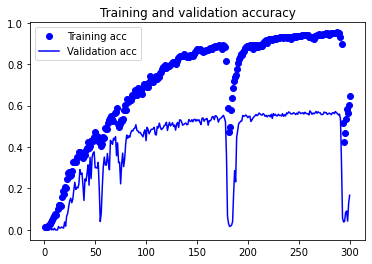

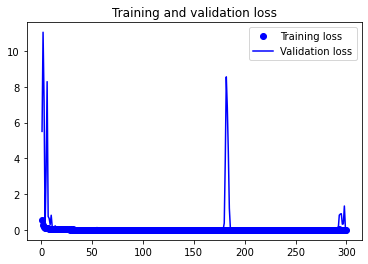

0.00967817846685648
0.08606331050395966


In [163]:
print(history.history.keys())

iou_score = history.history['iou_score']
val_iou_score = history.history['val_iou_score']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(iou_score) + 1)

plt.plot(epochs, iou_score, 'bo', label='Training acc')
plt.plot(epochs, val_iou_score, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

print(history.history['loss'][-1])
print(history.history['val_loss'][-1])

In [164]:
results = model.evaluate(x_test, y_test)

1/1 [==============================] - 1s 740ms/step - loss: 0.1048 - iou_score: 0.2170


In [ ]:
model_path = "models/"
model.save(f"{model_path}spoke_{140}im_{300}e_{'resnet34'}.h5")

In [1]:

from tensorflow import keras
model = keras.models.load_model('models/spoke_140im_300e_resnet34.h5', compile=False)

# THIS IS CRAZY

# Lets test with images outside of train/test

In [16]:
remaining_dataset = sorted(glob.glob("../datasets/"+"light_spokes_no_training/*.png"), key=get_order)

In [17]:
len(remaining_dataset)

797

In [18]:
remaining_test = []
filenames = []

for img_path in remaining_dataset:
    filenames.append(img_path.split("/")[-1])
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    remaining_test.append(img)

In [19]:
len(remaining_test)

797

In [20]:
remaining_test = normalize(np.array(remaining_test), axis=1)

W1630831573.png


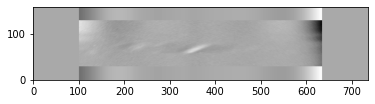

1/1 [==============================] - 0s 30ms/step


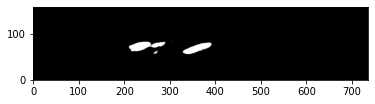

W1630832115.png


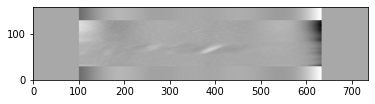

1/1 [==============================] - 0s 32ms/step


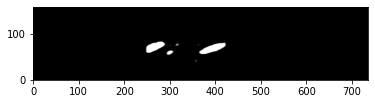

W1630832657.png


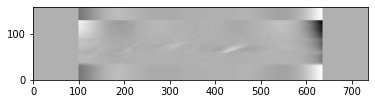

1/1 [==============================] - 0s 27ms/step


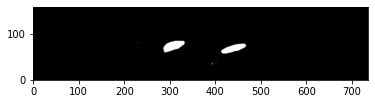

W1630833199.png


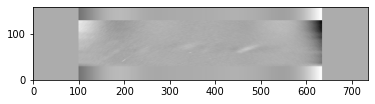

1/1 [==============================] - 0s 24ms/step


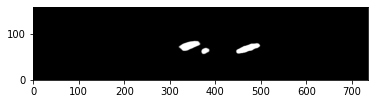

W1630833741.png


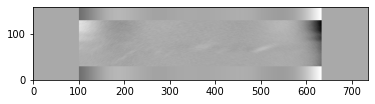

1/1 [==============================] - 0s 29ms/step


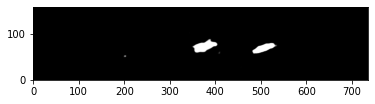

W1630834283.png


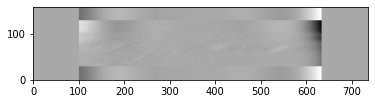

1/1 [==============================] - 0s 25ms/step


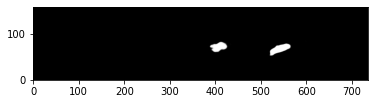

W1630834825.png


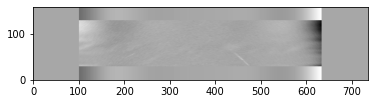

1/1 [==============================] - 0s 30ms/step


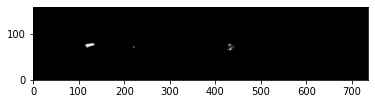

W1630835367.png


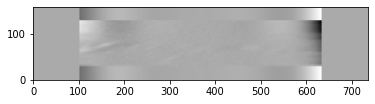

1/1 [==============================] - 0s 25ms/step


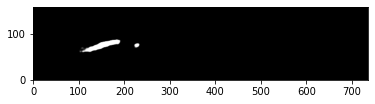

W1630835909.png


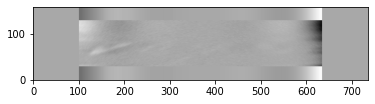

1/1 [==============================] - 0s 27ms/step


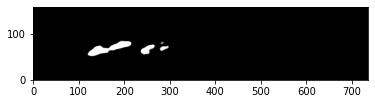

W1630836993.png


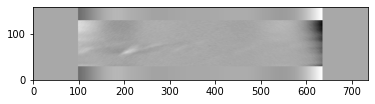

1/1 [==============================] - 0s 26ms/step


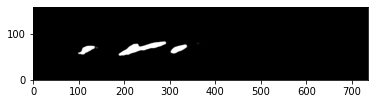

In [25]:
for filename, img in zip(filenames[340:350], remaining_test[340:350]):
    print(filename)
    plt.imshow(img, cmap="gray", origin="lower")
    plt.show()
    img = img.reshape((1, 160, 736))
    # print(img[0][0])
    



    prediction = model.predict(img)
    plt.imshow(prediction[0], cmap='gray', origin = 'lower')
    plt.show()
    prediction = []
    
    